#

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.stats import linregress

In [3]:
from dask.distributed import Client, LocalCluster, wait

In [4]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=32e9,
                       silence_logs=50)
client = Client(address=cluster)

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39045 instead
  http_address["port"], self.http_server.port


In [5]:
client

Client Scheduler: tcp://127.0.0.1:45525 Dashboard: http://127.0.0.1:39045/status,Cluster Workers: 4 Cores: 8 Memory: 128.00 GB


## Read NEMO grid

In [7]:
ds_mesh = xr.open_dataset('/data/user/jkjellsson/orca05_mesh_mask.nc')
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_3D = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})

## Read NEMO

In [9]:
exp_list = ['focioifs-merge14']

In [10]:
# NEMO grid T
ds_t_all = []
for exp in exp_list:
    t = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/nemo/*1m*grid_T.nc' % (exp,)
    ds_t = xr.open_mfdataset(t,combine='by_coords').rename({'time_counter':'time'})
    ds_t_all.append(ds_t)

## Volume-averaged temperature

<xarray.DataArray (time: 2618)>
dask.array<truediv, shape=(2618,), dtype=float64, chunksize=(120,), chunktype=numpy.ndarray>
Coordinates:
    time_centered  (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
  * time           (time) datetime64[ns] 1850-01-16T12:00:00 ... 2069-12-16T12:00:00


KilledWorker: ("('sum-sum-aggregate-e7baf36755de1e9e38958af2b486ba54', 74)", <Worker 'tcp://127.0.0.1:38129', name: 2, memory: 0, processing: 8>)

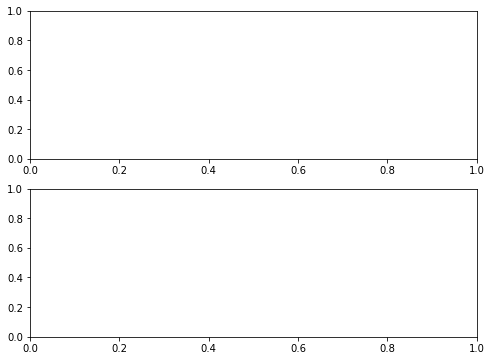

In [12]:
fig, ax = plt.subplots(2,1,figsize=(8,6))

for i in range(0,len(exp_list)):
    ds_t = ds_t_all[i]
    exp = exp_list[i]
    
    # Ocean temperature
    tot_vol = (da_orca05_volume * da_orca05_mask_3D).sum(('x','y','deptht')) 
    toce = (ds_t['votemper'] * da_orca05_volume * da_orca05_mask_3D).sum(('x','y','deptht')) / tot_vol
    print(toce)
    
    # Surface heat flux
    tot_area = (da_orca05_area * da_orca05_mask).sum(('x','y')) 
    hflux = (ds_t['sohefldo'] * da_orca05_mask * da_orca05_area).sum(('x','y')) / tot_area
    
    # Annual mean
    toce_mean = toce.groupby('time.year').mean('time')
    toce_mean.plot(ax=ax[0],alpha=1,label=exp)
    
    hflux_mean = hflux.groupby('time.year').mean('time')
    hflux_mean.plot(ax=ax[1],alpha=1,label=exp)
    
ax[0].legend()
ax[0].set_ylabel('Volume-mean ocean temperature')
ax[1].set_ylabel('Area-mean downward surface heat flux [W/m2]')
fig.tight_layout()
fig.savefig('volmean_ocean_temp.pdf',format='pdf')